### 기본 셋팅 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns 
from scipy import stats
import os
import platform
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


df =pd.read_csv("../../data/2.processed/processed_for_analysis.csv")


### 다중회귀 (단순회귀에서 다뤘던 부분 + 중요해 보였던 부분)

#### 종속변수(범죄 유형) 결정

In [3]:
targets = {
    "절도": "절도범죄_전체",
    "풍속": "풍속범죄_전체",
    "지능": "지능범죄_재산범죄",
    "마약": "마약범죄_전체",
}

#### 독립변수(요인) 결정 

In [4]:
x_cols = [
    "노년기_비율",
    "1인가구비율",
    "여성_비율", #남성 비율은 여성_비율과 중복이라 제외
    "CCTV",
    "경찰서수",
]

#### 다중회귀 모델 적합 코드 

In [5]:
def run_multiple_ols(df,y_col, x_cols):
    use_cols = [y_col] + x_cols
    y = np.log1p(df[y_col])
    X = df[x_cols]
    X = sm.add_constant(X)

    model = sm.OLS(y,X).fit()
    print(f"\n=== 다중회귀: {y_col} ~ {', '.join(x_cols)} ===")
    print(model.summary())
    return model



#### 범죄 유형별로 돌려보기

In [6]:
models = {}
for name, y_col in targets.items():
    models[name] = run_multiple_ols(df, y_col, x_cols)


=== 다중회귀: 절도범죄_전체 ~ 노년기_비율, 1인가구비율, 여성_비율, CCTV, 경찰서수 ===
                            OLS Regression Results                            
Dep. Variable:                절도범죄_전체   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     32.35
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           4.33e-25
Time:                        14:28:13   Log-Likelihood:                 5.2420
No. Observations:                 243   AIC:                             1.516
Df Residuals:                     237   BIC:                             22.47
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

### The condition number is large, 1.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.(해결을 위한 VIF확인) 

In [7]:
# 1. VIF 확인 코드 (다중공선성 진단)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 상수항이 포함된 X 데이터 생성
X = df[x_cols]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
# VIF가 10을 넘는 변수는 제거를 고려해야 합니다.

  feature          VIF
0   const  1272.296225
1  노년기_비율     1.697090
2  1인가구비율     1.232511
3   여성_비율     1.017694
4    CCTV     1.560232
5    경찰서수     1.215957


### 청년기 비율과 노년기 비율이 다중공선성 문제 일으킬 확률이 매우 높음 그렇기 때문에 청년기 비율(설명력이 떨어지는)을 제거 하고 돌림

In [8]:
# 1. VIF 확인 코드 (다중공선성 진단)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 상수항이 포함된 X 데이터 생성
X = df[x_cols]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
# VIF가 10을 넘는 변수는 제거를 고려해야 합니다.

  feature          VIF
0   const  1272.296225
1  노년기_비율     1.697090
2  1인가구비율     1.232511
3   여성_비율     1.017694
4    CCTV     1.560232
5    경찰서수     1.215957


#### 2,4 모델(풍속범죄, 마약범죄)는 설명령이 낮음 

#### 계수로 비교 불가(단위 다름), 회계계수 표준화 모델 함수 

In [9]:
def run_multiple_ols_standardized(df, y_col, x_cols):
    use_cols = [y_col] + x_cols
    data = df[use_cols].dropna()
    
    X = data[x_cols]
    y = data[y_col]
    
    # z-score 표준화
    X_z = (X - X.mean()) / X.std()
    y_z = (y - y.mean()) / y.std()
    
    X_z = sm.add_constant(X_z)
    model = sm.OLS(y_z, X_z).fit()
    return model

#### 범죄별 표준화 계수 테이블 생성

In [10]:
import pandas as pd

std_models = {name: run_multiple_ols_standardized(df, y_col, x_cols)
              for name, y_col in targets.items()}

rows = []
for crime_name, m in std_models.items():
    for var in x_cols:
        rows.append({
            "범죄유형": crime_name,
            "변수": var,
            "표준화계수": m.params[var],
            "p값": m.pvalues[var],
            "R2": m.rsquared
        })

coef_df = pd.DataFrame(rows)
coef_df

,범죄유형,변수,표준화계수,p값,R2
0,절도,노년기_비율,-0.439172,1.293240e-09,0.325417
1,절도,1인가구비율,0.441955,1.612825e-12,0.325417
2,절도,여성_비율,0.282918,3.272058e-07,0.325417
3,절도,CCTV,0.056848,3.944859e-01,0.325417
4,절도,경찰서수,-0.078377,1.840592e-01,0.325417
5,풍속,노년기_비율,-0.061184,4.647660e-01,0.024904
6,풍속,1인가구비율,0.067188,3.463842e-01,0.024904
7,풍속,여성_비율,0.130186,4.536268e-02,0.024904
8,풍속,CCTV,0.012207,8.790320e-01,0.024904
9,풍속,경찰서수,0.022019,7.558433e-01,0.024904


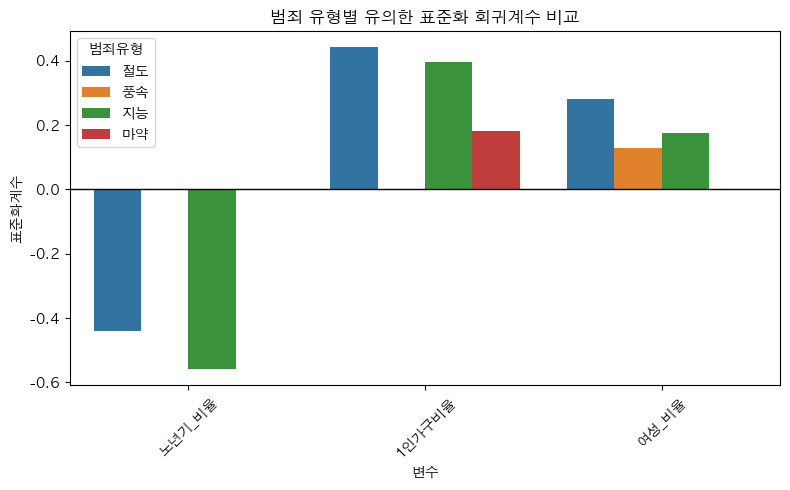

In [11]:

plt.figure(figsize=(8,5))
sns.barplot(
    data=coef_df[coef_df["p값"] < 0.05],  # 유의한 것만 보려면 필터
    x="변수", y="표준화계수", hue="범죄유형"
)
plt.axhline(0, color="black", linewidth=1)
plt.title("범죄 유형별 유의한 표준화 회귀계수 비교")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
def plot_actual_vs_pred(model, y_series, title):
    fitted = model.fittedvalues
    y_used = y_series.loc[model.model.data.row_labels]
    
    plt.figure(figsize=(5,4))
    plt.scatter(fitted, y_used, alpha=0.6)
    min_v, max_v = min(fitted.min(), y_used.min()), max(fitted.max(), y_used.max())
    plt.plot([min_v, max_v], [min_v, max_v], 'r--')
    plt.xlabel("예측값")
    plt.ylabel("실제값")
    plt.title(title)
    plt.grid(True)
    plt.show()

#### 유의한 모델 plot


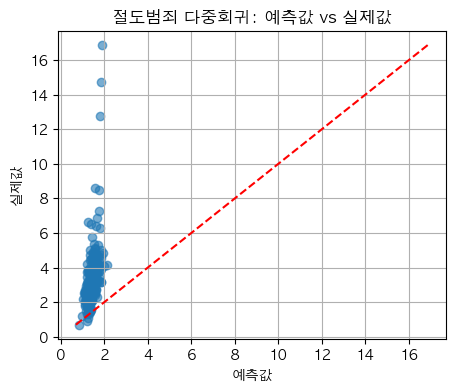

In [13]:
plot_actual_vs_pred(models["절도"],
                    df["절도범죄_전체"],
                    "절도범죄 다중회귀: 예측값 vs 실제값")

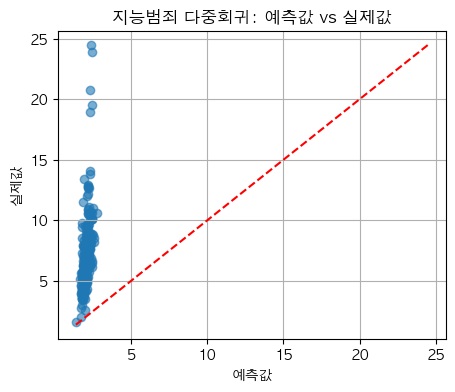

In [14]:
plot_actual_vs_pred(
    models["지능"],
    df["지능범죄_재산범죄"],
    "지능범죄 다중회귀: 예측값 vs 실제값"
)

### 결론 

### 다중회귀 분석 결과 (가설 관점 정리)

#### (1) 절도범죄_전체

-  R² = 0.406, Adj R² = 0.393으로 **단순회귀(0.146)에 비해 설명력이 크게 향상**되었다.
- 유의한 변수: **1인가구비율(+)**, **여성_비율(+)**, **노년기_비율(−)**  
  - 1인가구비율이 1%p 증가할수록 절도범죄율은 증가(양의 계수, p<0.001)  
  - 여성_비율이 높을수록 절도범죄율 증가(양의 계수, p<0.001)  
  - 노년기_비율이 높을수록 절도범죄율 감소(음의 계수, p<0.05)  
  “초기 다중회귀 모형에서는 청년기_비율의 계수≈0, p≈0.91로 유의하지 않았으며,
이후 다중공선성 및 해석 용이성을 고려해 최종 모형에서는 청년기_비율 변수를 제외하였다.”
  **1인가구 및 여성 인구 비중 등 다른 인구구조 특성과의 공선성**에 의한 간접 효과로 보는 것이 타당하다.

**→ 가설 관점 정리**
- **B1: 청년기 비율↑ → 절도범죄율↑**  
  - 단순회귀에서는 지지, 다중회귀에서는 비유의 →  
    **다른 변수들을 통제하면 ‘독립적인 효과’는 사라짐 → 실질적으로 기각에 가까움**
---

#### (2) 지능범죄_재산범죄



**→ 가설 관점 정리**

- **B3: 노년기 비율↑ → 지능범죄율↓**  
  - 단순·다중회귀 모두에서 음(-)의 계수, p<0.01 → **B3는 강하게 지지**.


#### (3) 풍속범죄_전체

- R² ≈ 0.162, Adj R² ≈ 0.144로 설명력은 여전히 높지는 않지만,
  F-검정 p < 0.001로 모형 전체는 통계적으로 유의하다.
- 유의한 변수: 1인가구비율(+), 여성_비율(+), 노년기_비율(−)
  - 1인가구비율↑, 여성_비율↑ → 풍속범죄율 증가 경향
  - 노년기_비율↑ → 풍속범죄율 감소 경향

 
**→ 가설 관점 정리**

- **B2: 청년기 비율↑ → 풍속범죄율↑**  
  - 단순회귀에서도 비유의, 다중회귀에서도 비유의 + R² 거의 0 →  
    **B2는 명확히 기각**.


---

#### (4) 마약범죄_전체

- R² ≈ 0.059, Adj R² ≈ 0.039으로 설명력은 낮지만,
   F-검정 p ≈ 0.013으로 모형 전체는 유의하다.
- 변수별로 보면:
  - **여성_비율**: 약한 음(-)의 관계, p≈0.048 (유의)  
    → 여성 비중이 높을수록 마약범죄율은 소폭 감소하는 경향
  - 노년기_비율(p≈0.060): 0.05 근처의 경계선 수준  
  - 1인가구비율, CCTV, 경찰서수: p>0.3로 비유의
- 단순회귀에서 유의했던 1인가구비율의 효과는,  
  **다른 인구구조 변수를 함께 고려하면 사라지는 것**으로 나타났다.

**→ 가설 관점 정리**

- **B4: 1인가구 비율↑ → 마약범죄율↑**  
  - 단순회귀: 양(+) 계수, p<0.01이지만 R² 매우 낮음  
  - 다중회귀: 1인가구비율 계수 비유의 →  
    **다른 변수들을 통제하면 독립적인 효과가 사라짐**  
  → **“단순회귀 수준에서는 약하게 지지되지만, 다중회귀 기준에서는 지지되지 않음”**이라고 정리하는 것이 적절하다.